In [1]:
import pandas as pd
import numpy as np

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head(10)

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1


In [5]:
products.sentiment.value_counts()

 1    26579
-1    26493
Name: sentiment, dtype: int64

In [6]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [7]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

In [8]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [9]:
important_words_json = pd.read_json('important_words.json')
important_words_json.columns = ['word']
important_words = important_words_json.word.tolist()

In [10]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [12]:
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
train_index = pd.read_json('module-10-assignment-train-idx.json')
train_index.columns = ['indexvalue']
id_train = train_index.indexvalue.tolist()

validation_index = pd.read_json('module-10-assignment-validation-idx.json')
validation_index.columns = ['indexvalue']
id_validation = validation_index.indexvalue.tolist()

In [14]:
train_data = products.iloc[id_train]
validation_data = products.iloc[id_validation]

In [15]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [16]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
feature_matrix_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We will use the **same code** as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [18]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1 / (1 + np.exp(-score))
    
    # return predictions
    return predictions

In [19]:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])

correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),          1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_predictions = np.array( [ 1./(1+np.exp(-correct_scores[0])), 1./(1+np.exp(-correct_scores[1])) ] )

print 'The following outputs must match '
print '------------------------------------------------'
print 'correct_predictions           =', correct_predictions
print 'output of predict_probability =', predict_probability(dummy_feature_matrix, dummy_coefficients)

The following outputs must match 
------------------------------------------------
correct_predictions           = [ 0.98201379  0.26894142]
output of predict_probability = [ 0.98201379  0.26894142]


## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 assignment that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 assignment, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 
Complete the following code block:

In [20]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
        # Return the derivative
    return derivative

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [21]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


** Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [22]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Complete the following function to fit a logistic regression model using gradient ascent:

In [27]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * derivative * (1./batch_size)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

**Note**. In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.

### Checkpoint


The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [28]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient ascent

For the remainder of the assignment, we will compare stochastic gradient ascent against batch gradient ascent. For this, we need a reference implementation of batch gradient ascent. But do we need to implement this from scratch?

**Quiz Question:** For what value of batch size `B` above is the stochastic gradient ascent function **logistic_regression_SG** act as a standard gradient ascent algorithm? Hint: consider the training set we are using now.

## Running gradient ascent using the stochastic gradient ascent implementation

We now **run stochastic gradient ascent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [29]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


Now run **batch gradient ascent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [30]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [31]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [33]:
num_passes

10

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

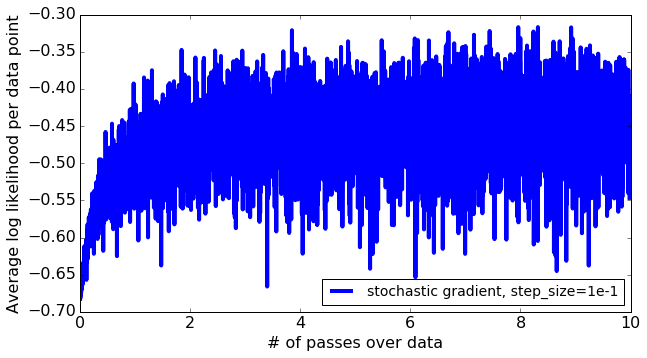

In [35]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

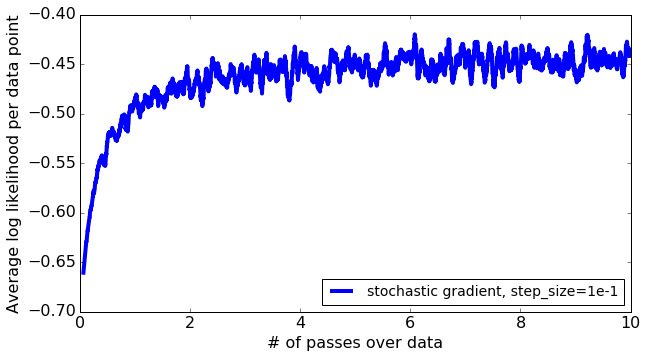

In [36]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [38]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

In [39]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

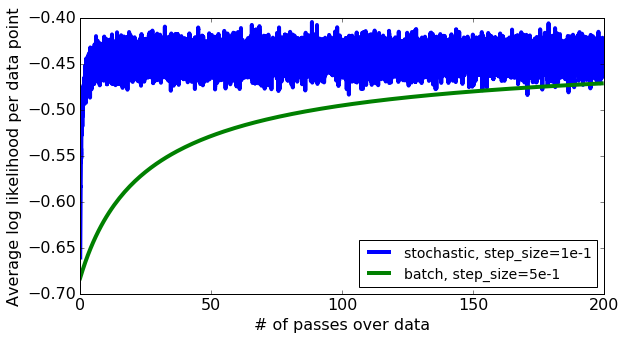

In [40]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

**Quiz Question**: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent? 

1. It's always better
2. 10 passes
3. 20 passes
4. 150 passes or more

## Explore the effects of step sizes on stochastic gradient ascent

In [41]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp



Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -14.68554926
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -3.16480922
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -8.15954538
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -20.99164300
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -11.03411798
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -4.79046499
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -5.88019603
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -6.54725616
Iteration 2000: Average log likelihood (of data points in batch [09200:09300]) = -13.66809927
Iteration 3000: Average log likelihood (of data points in batch [13800:13900]) = -2.14531598
Iteration 4000: Average log likelihood (of data points in batch [

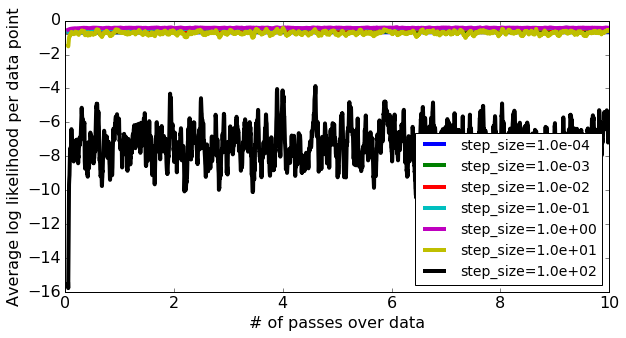

In [42]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

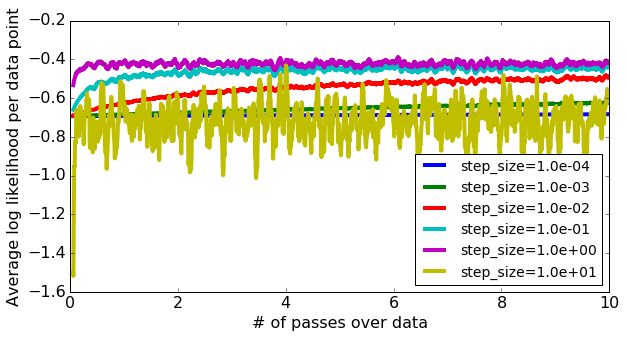

In [43]:
# Now, let us remove the step size step_size = 1e2 and plot the rest of the curves.
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)